# House Prices - Advanced Regression Techniques (Kaggle)

Run after following notebooks are run:
1. 01 Data Cleaning

#### Development Ideas
* research how to systematically loop through all relationship graphs
* https://medium.com/@sebastiencallebaut/kaggle-housing-competition-learn-with-a-step-by-step-solution-bdca19cc8eed
* might use pointplot instead of stripplot

In [1]:
### set up libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy.stats as stats # Used for Cramer's V computation

pd.options.display.max_rows = 100

## Load Data

In [2]:
### load data (cleaned)
train = pd.read_csv('train_clean.csv')

### convert all object datatypes to category
for col in train.select_dtypes(include='object'):
    train[col] = train[col].astype('category')

### convert additional columns to category datatype
train['MSSubClass'] = train['MSSubClass'].astype('category')

### drop ID column
train.drop('Id', axis=1, inplace=True)

## Univariate (One-way) Analysis

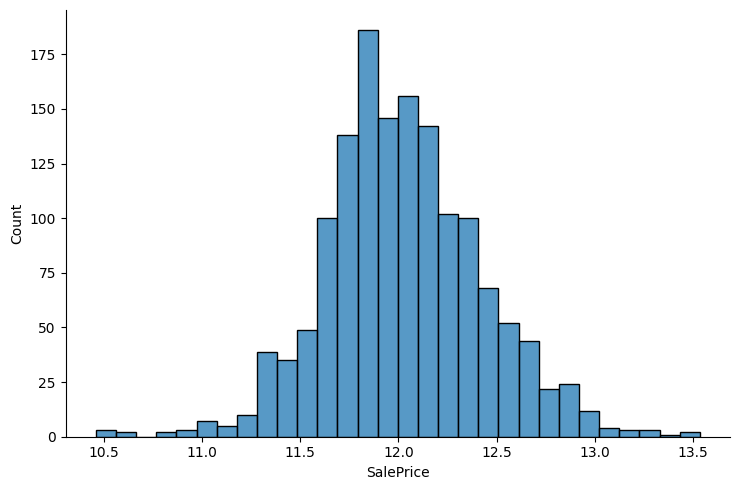

In [3]:
### histogram of sale price
g=sns.displot(data=train, x='SalePrice', bins=30, aspect=1.5)

### Categorical Variables

Observations
* Variables where almost all houses are in the same category - hence can be dropped
    * 'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC', 'MiscFeature', 
* Categorical variables that didn't seem predictive (at least not on its own):
    * 'Alley','LandSlope', 'Condition1', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'HeatingQC', 'Functional', 'remodel_flag'
* Potential drivers of higher sale price:
    * MSSubClass = 60
    * LotShape = IR2 or IR3
    * LotConfig = CulDSac
    * Neighborhood
    * HouseStyle = 2Story
    * RoofStyle = Hip
    * MasVnrType = Stone
    * ExterQual/BsmtQual/HeatingQC/KitchenQual = Ex
    * Foundation = PConc
    * BsmtExposure = GD
    * CentralAir = Y
    * GarageType = BuiltIn
    * SaleType = New
    * SaleCondition = Partial

Ideas for feature engineering
* [x] Group categories with very few observations in to 'Other' category
* [x] SaleType - group into only 'new' or 'old'
* [ ] Qual/Cond variables - group Fa and TA together 

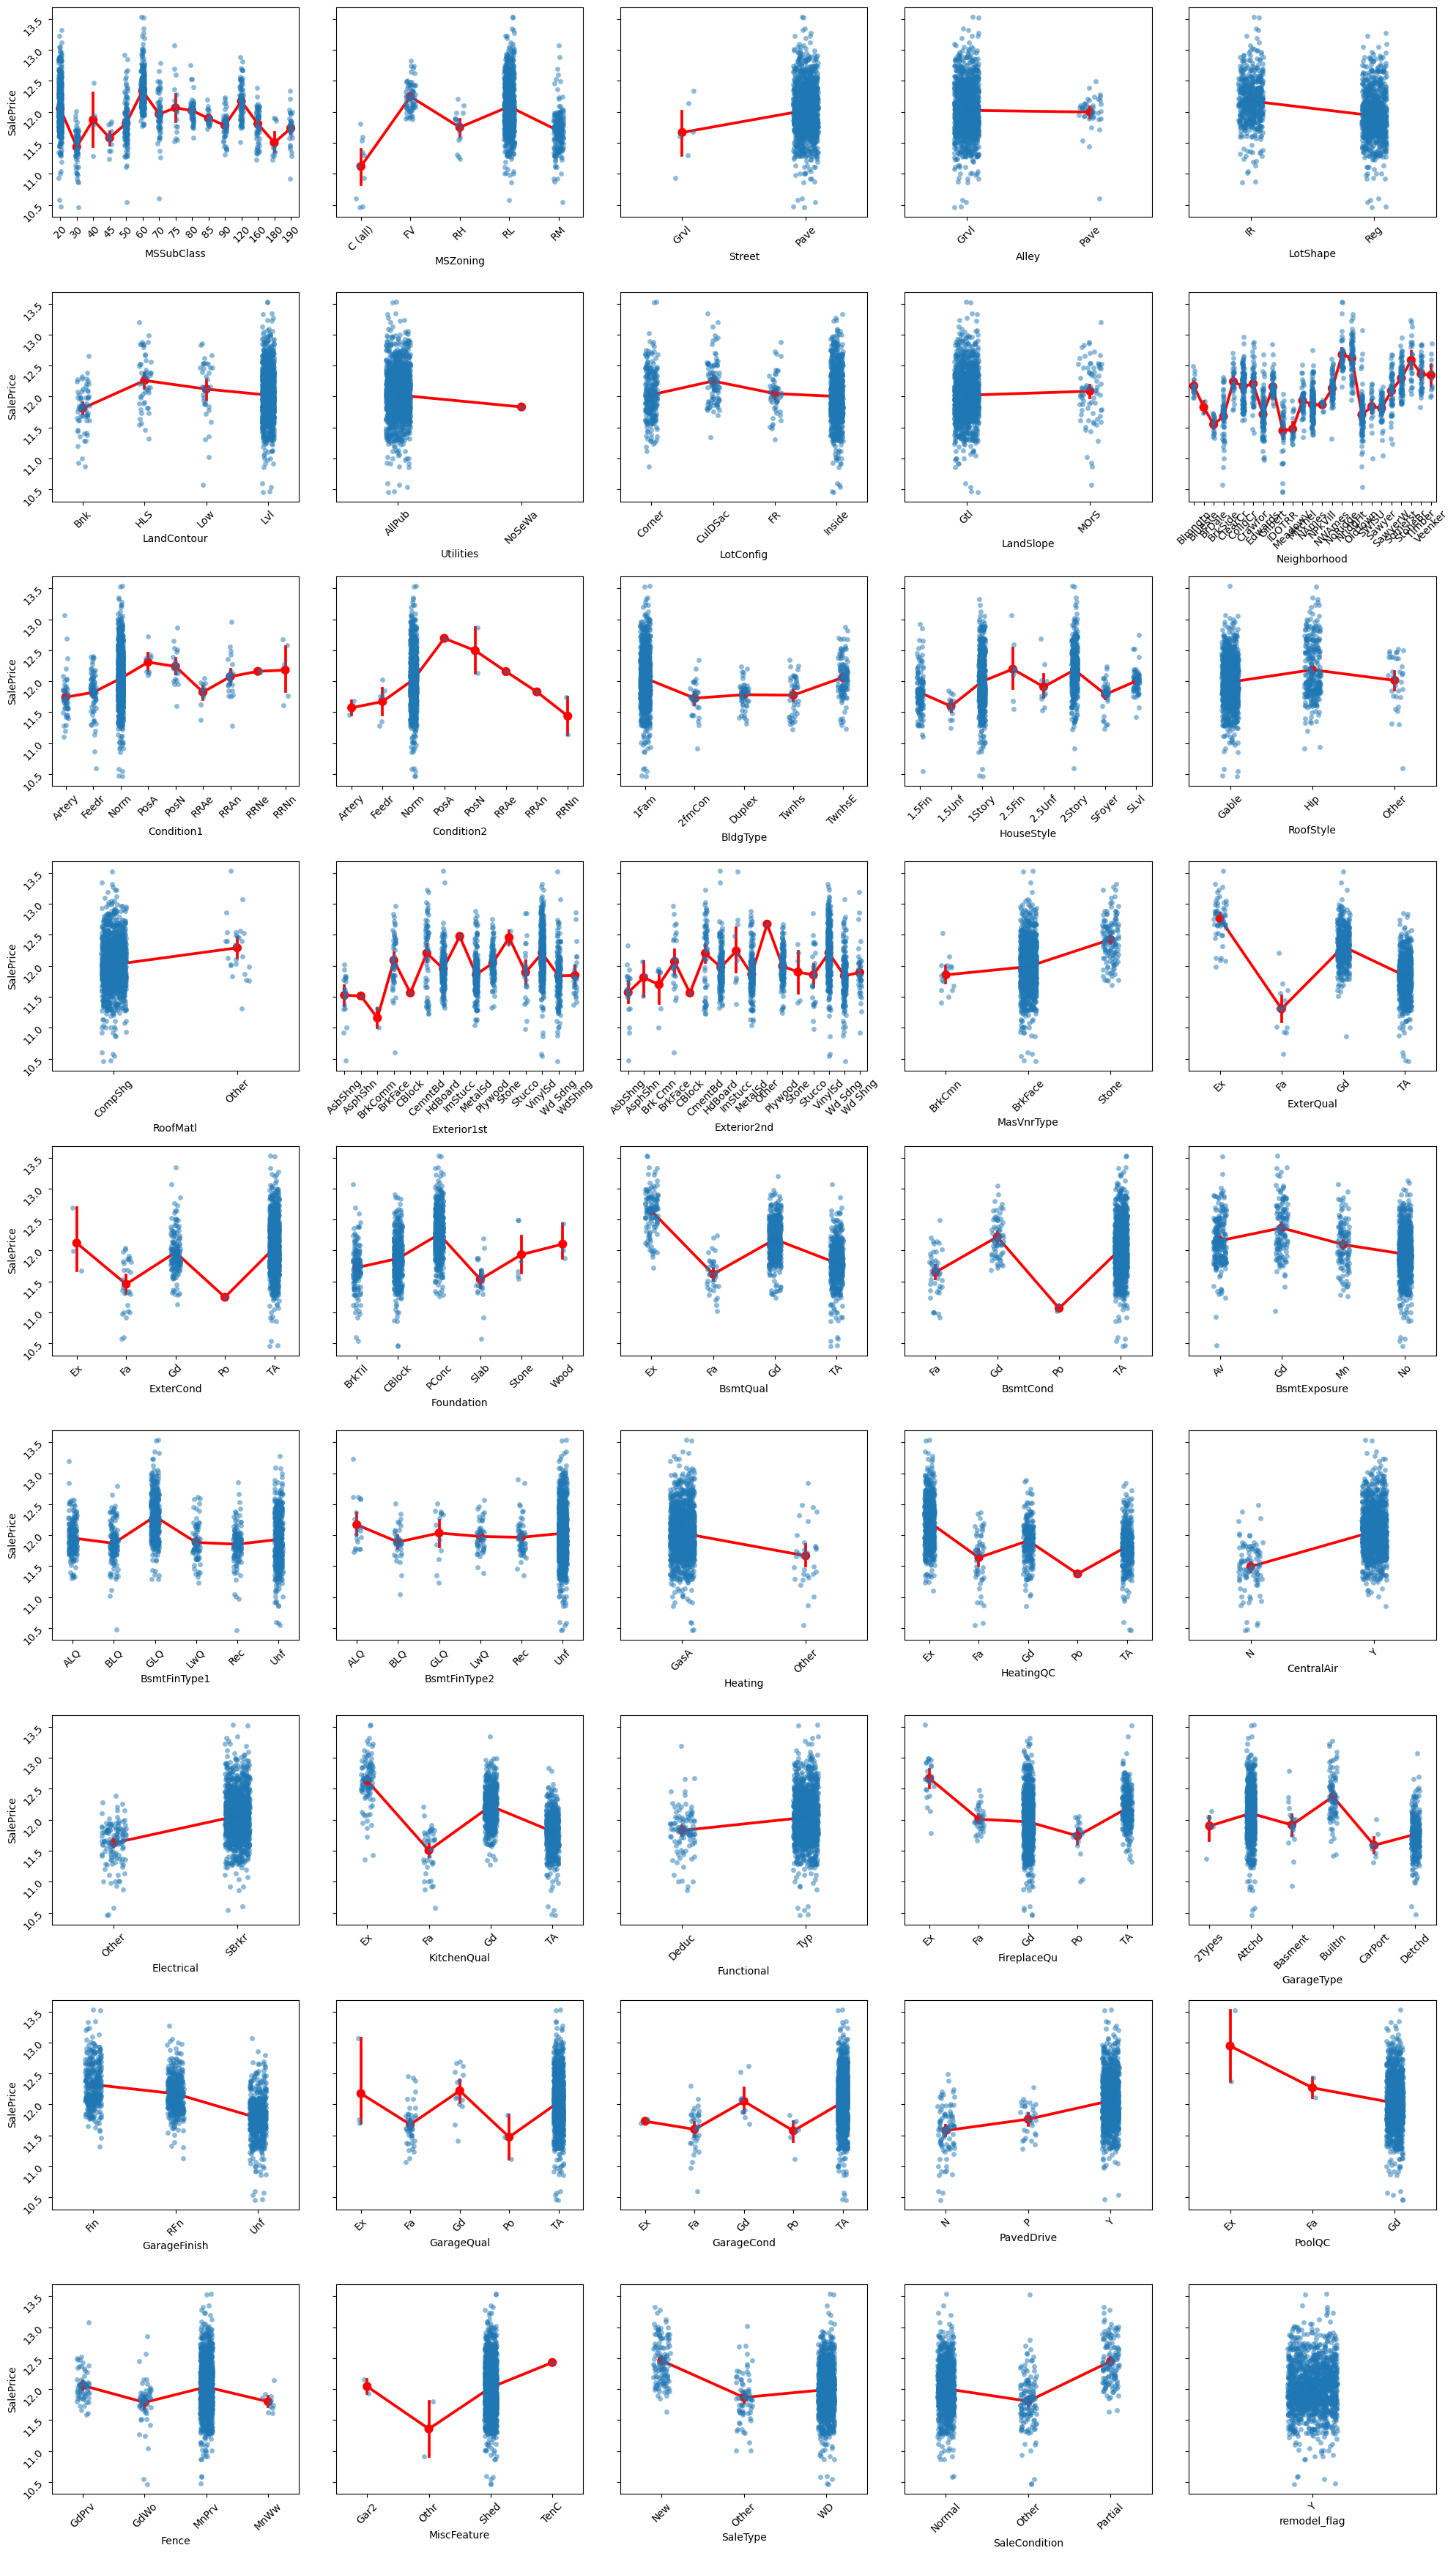

In [4]:
### list of all categorical variables
cols_cat = train.select_dtypes(include='category').columns.to_list()

### set up grid of subplots, then fill it with scatterplots of each categorical variable vs SalePrice
fig, axes = plt.subplots(ncols=5, nrows=9, figsize=(20,35), sharey=True)
for i, col in enumerate(cols_cat):
    ax = axes.ravel()[i]
    sns.stripplot(data=train, x=col, y='SalePrice', ax=ax, alpha=0.5)
    sns.pointplot(data=train, x=col, y='SalePrice', ax=ax, estimator='mean', color='red')
    # ax.set_yscale('log')
    ax.tick_params(labelrotation=45)
plt.tight_layout()

In [5]:
### drop variables where almost all houses are in the same category
train.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'PoolQC', 'MiscFeature'], 
            axis=1, inplace=True)

### Numerical Variables
Observations
* Variables that are 0 for almost all houses - hence can be dropped
    * 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
* More houses are sold in the warmer months
* Variables with outliers - may need to exclude
    * 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'
* Very few houses have more than one half bath - can combined full and half bath columns
* Most of the continuous variables are right skewed
* Potential drivers of higher sale price:
    * Most numerical variables have a somewhat linear relationship with log SalePrice
    * Strongest relationship are the variables that relate to area
    * Exception is BsmtUnfSF and BsmtFinSF2 and KitchenAbvGrd, which don't look like any relationship with SalePrice

Ideas for feature engineering
* [x] OverallQual & OverallCond - group <5 together


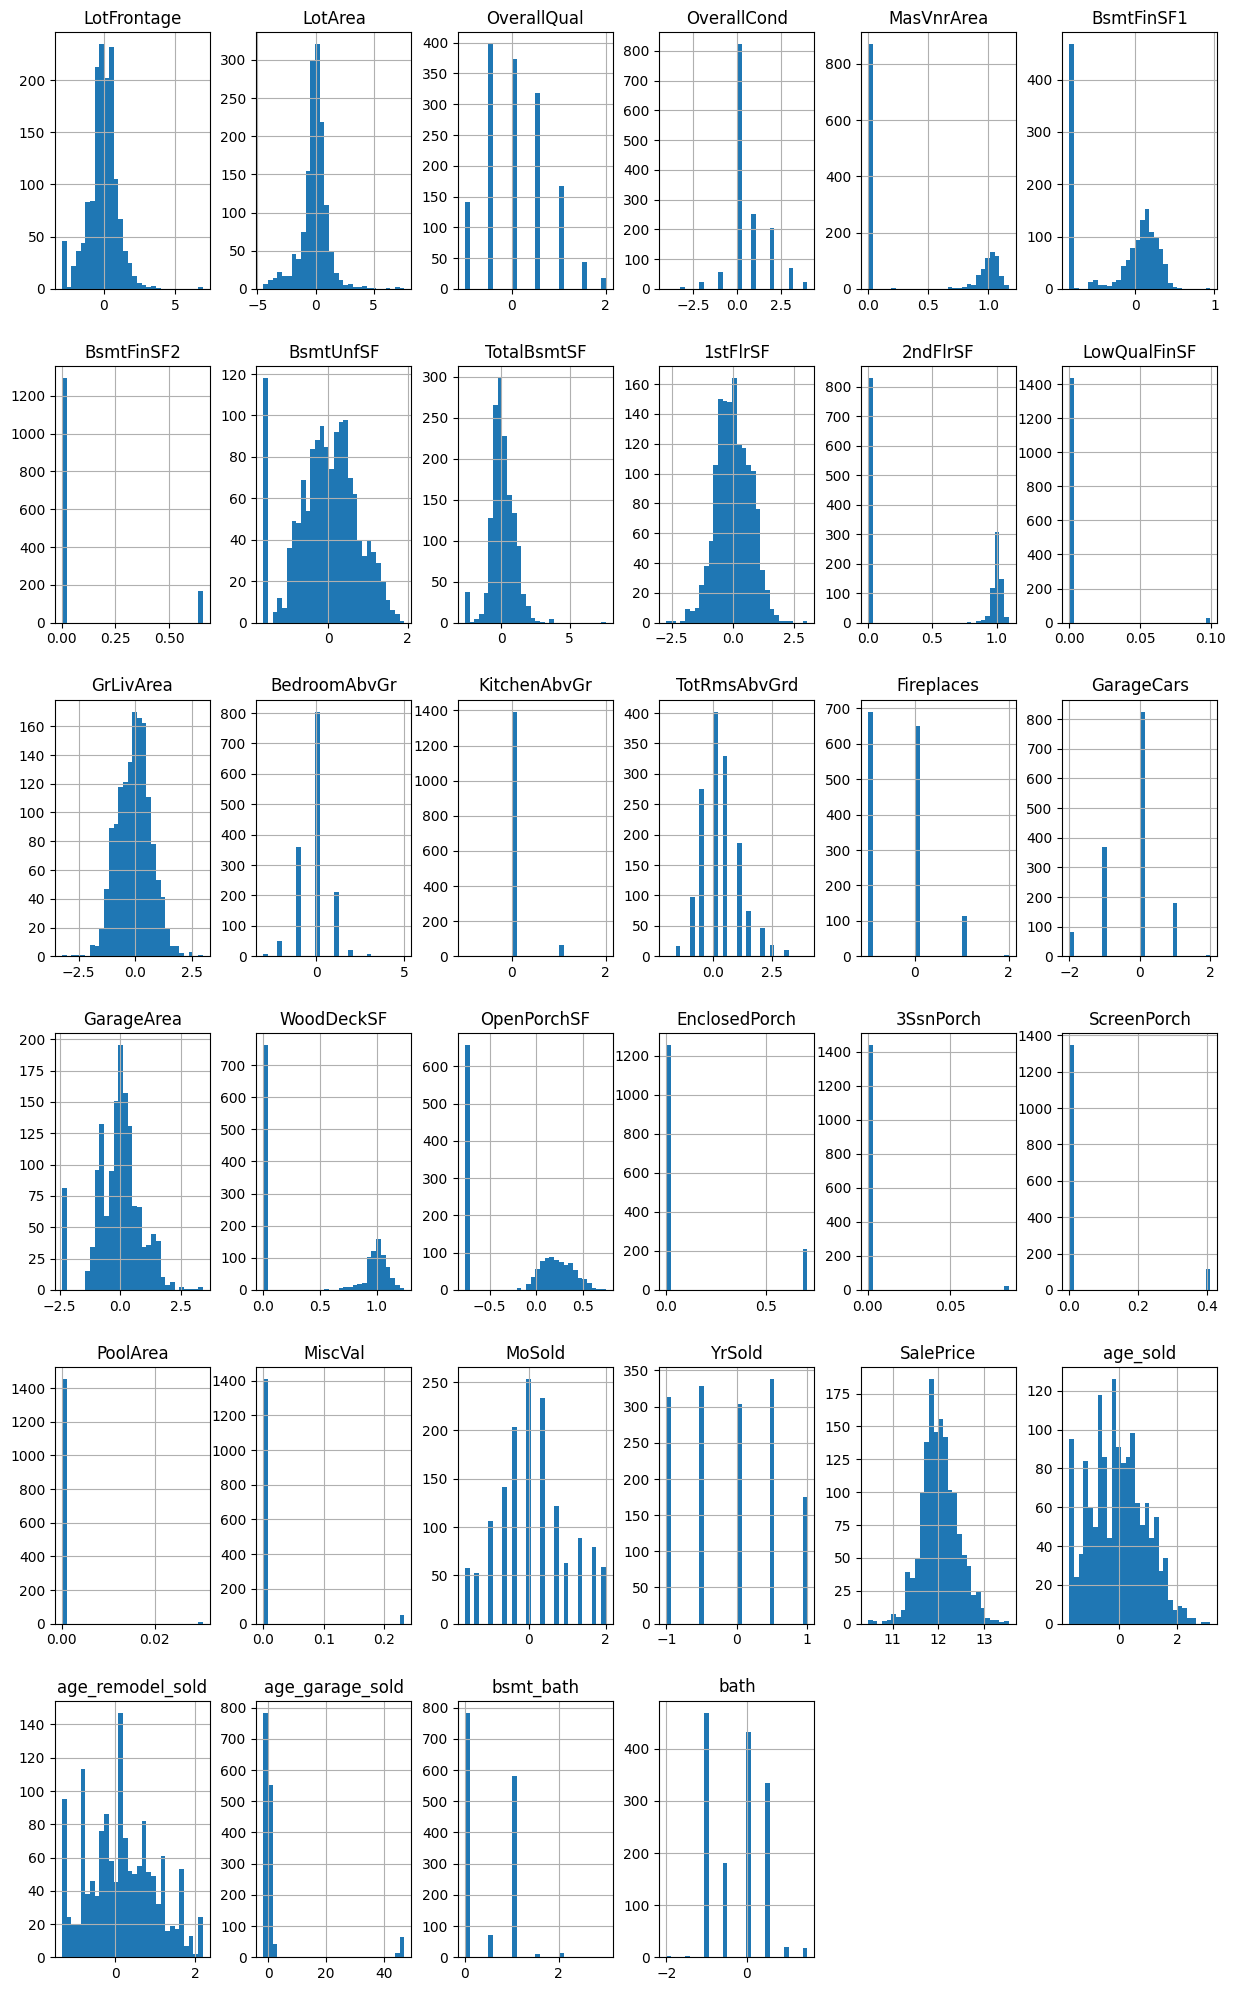

In [6]:
### Histograms of all numerical variables
train.hist(bins=30, figsize=(15,25), layout=(-1,6))
None

In [7]:
### drop variables that are 0 for almost all houses
## some variables mentioned above have already been dropped in data cleaning step
train.drop(['LowQualFinSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'], 
            axis=1, inplace=True)

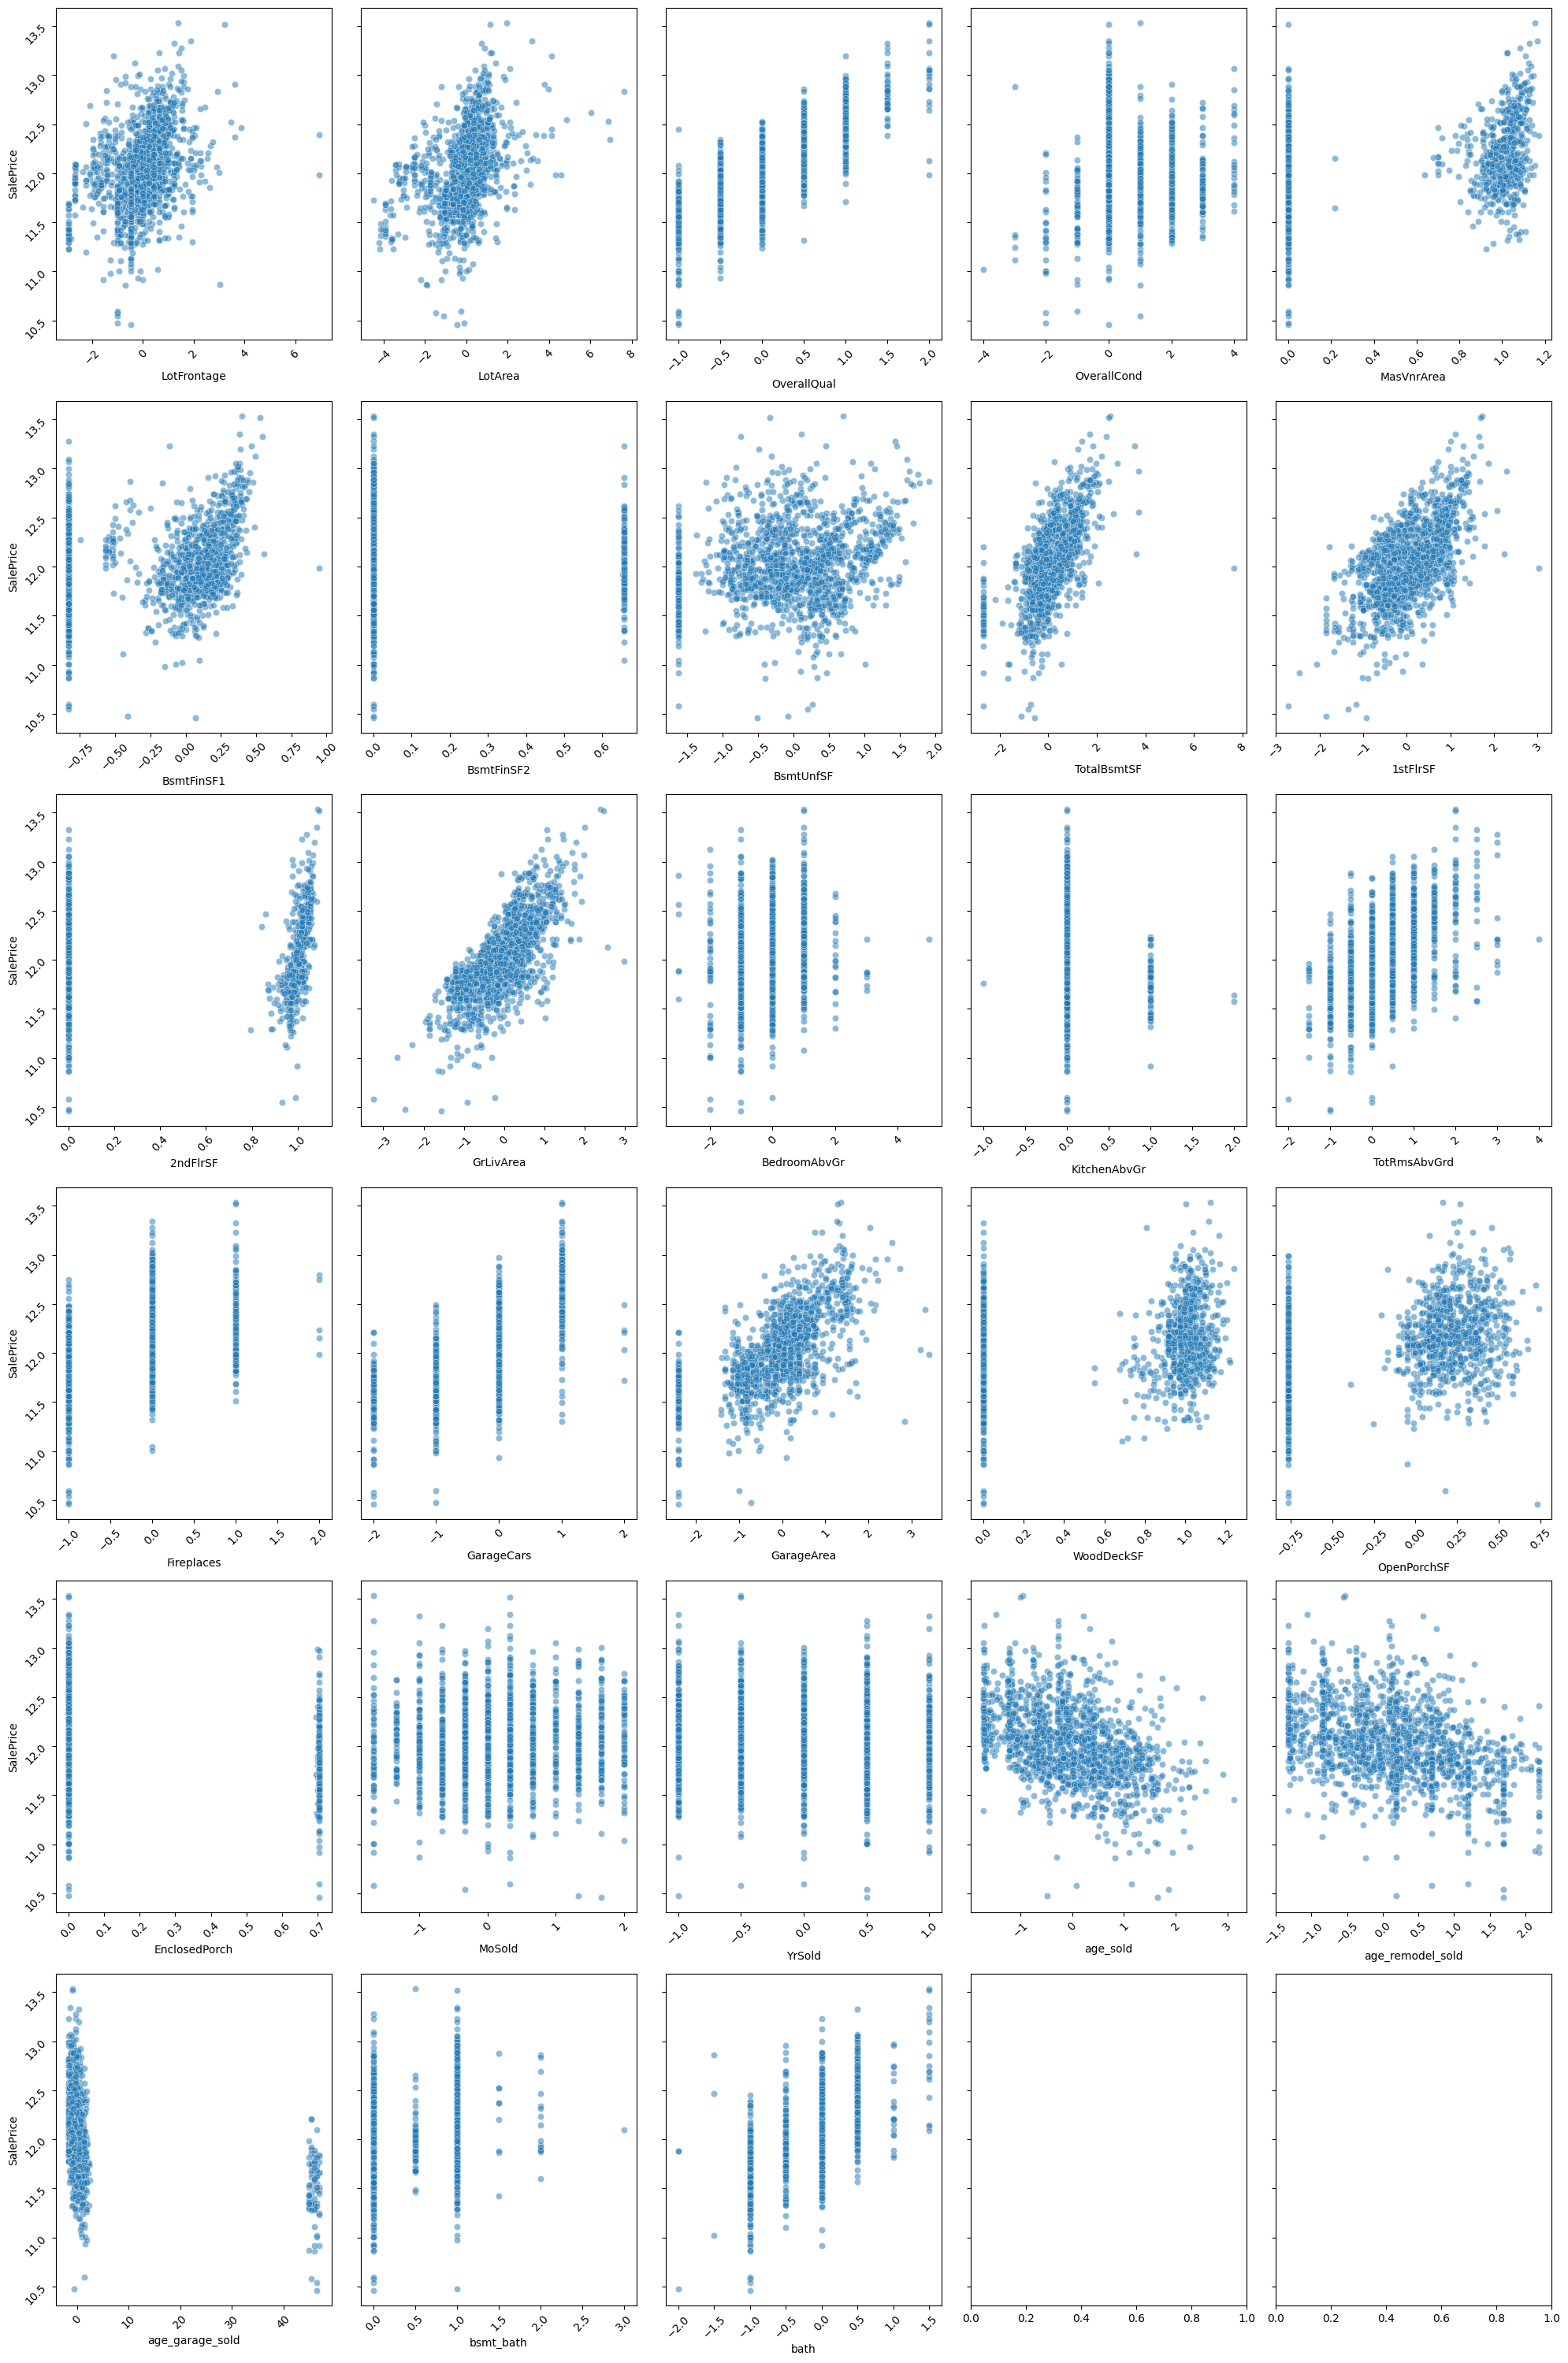

In [8]:
### list of all numerical variables
cols_num = train.select_dtypes(include=['float', 'int']).columns.to_list()
cols_num.remove('SalePrice')

### set up grid of subplots, then fill it with scatterplots of each numerical variable vs SalePrice
fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20,30), sharey=True)
for i, col in enumerate(cols_num):
    ax = axes.ravel()[i]
    sns.scatterplot(data=train, x=col, y='SalePrice', ax=ax, alpha=0.5)
    # ax.set_yscale('log')
    ax.tick_params(labelrotation=45)
plt.tight_layout()

#### Seasonality

Observations
* SalePrice are higher in warmer months
* Much more sales in warmer months

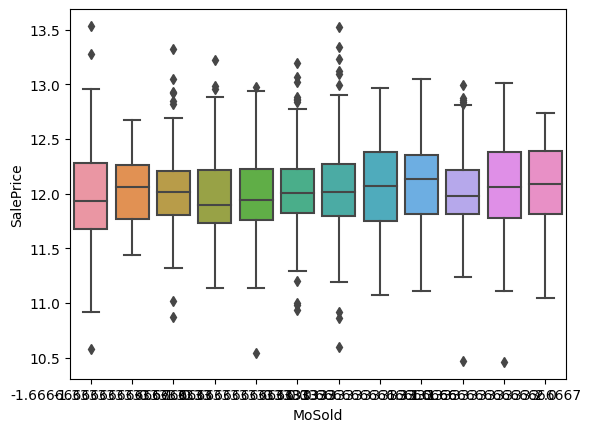

In [9]:
### Looking at distribution of SalePrice by sale month
g=sns.boxplot(data=train, x='MoSold', y='SalePrice')
# g.set(yscale='log')

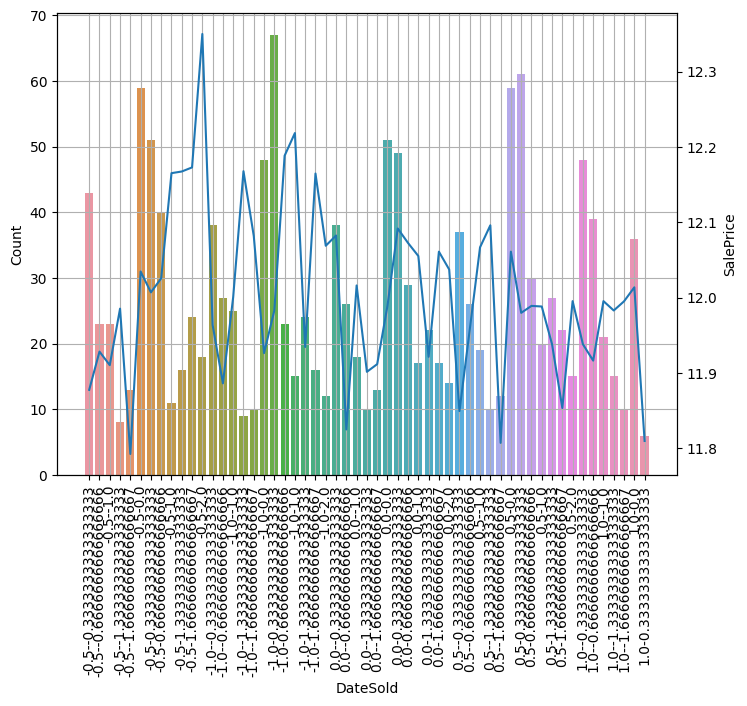

In [10]:
### Graph median SalePrice over time with exposure 
train['DateSold'] = train['YrSold'].astype(str) + '-' + train['MoSold'].astype(str).str.zfill(2)
datesold_median = train.groupby('DateSold').agg(Count=('DateSold', 'size'), SalePrice=('SalePrice', 'median')).reset_index()

## Graph exposure first
plt.figure(figsize=(8,6))
g=sns.barplot(data=datesold_median, x='DateSold', y='Count')
plt.xticks(rotation=90)
g.grid()

## Graph median sale price on top
h = g.twinx()
sns.lineplot(data=datesold_median, x='DateSold', y='SalePrice')
None

## Bivariate (Two-way) Analysis

### Categorical Variables


#### Cramer's V Matrix
Observations
* Strong correlation between:
    * HouseStyle and MSSubClass - both are split by # of stories/floors
* Variables with a lot of weak and medium correlations with other variables
    * ExterQual
    * MSSubClass
    * Neighbourhood
    * Foundation

<Axes: >

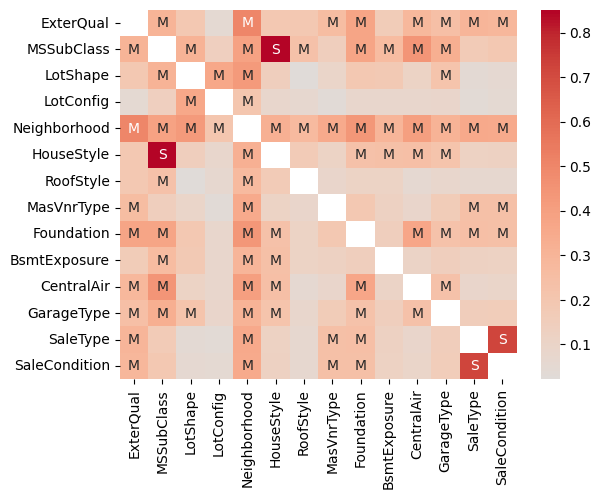

In [11]:
### create cramers_V calculation function
def cramers_V(data, var1, var2):
    cont_tbl = pd.crosstab(data[var1], data[var2])
    X2 = stats.chi2_contingency(cont_tbl, correction=False)[0]
    n = data.shape[0]
    min_dim = min(cont_tbl.shape)-1
    return( np.sqrt((X2/n)/min_dim) )

### Taking list of 'potential drivers' from univariate analysis
cats = ['ExterQual', 'MSSubClass', 'LotShape', 'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 
'MasVnrType', 'Foundation', 'BsmtExposure', 'CentralAir', 'GarageType', 'SaleType', 'SaleCondition']

### create cramers_V association matrix and fill in
crmV_matrix = pd.DataFrame(data=0, index=cats, columns=cats, dtype=float)

for i, var1 in enumerate(cats):
    for j, var2 in enumerate(cats):
        crV = cramers_V(train,var1,var2)
        crmV_matrix.iat[i,j] = crV

# Create S/M/W annotations for correlation matrix
crmV_annot = np.where((crmV_matrix)>0.6, "S", np.where((crmV_matrix)>0.2, "M", ""))

### create heatmap of cramers V association
sns.heatmap(data=crmV_matrix, center=0, cmap='coolwarm', mask=np.eye(len(crmV_matrix)), annot=crmV_annot, fmt='', xticklabels=True, yticklabels=True)

#### Facet by ExterQual
ExterQual - seems to be strong predictor based on univariate analysis

Observations
* A lot of patterns in other categorical variables disappear for ExterQual = 'Gd' and 'Ex'
* Some variables pattern disappear in ExterQual = 'TA' but still exist in 'Gd' and 'Ex'
    * 'RoofStyle', 'GarageType'

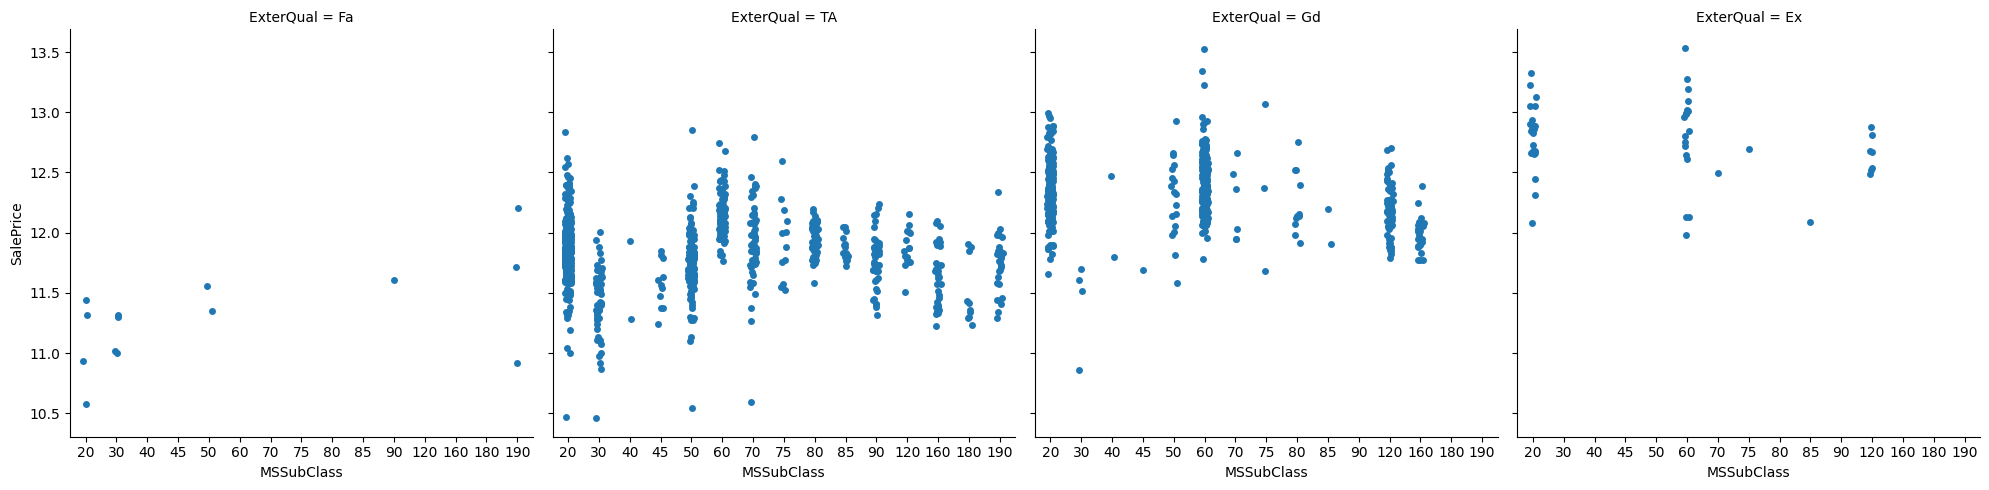

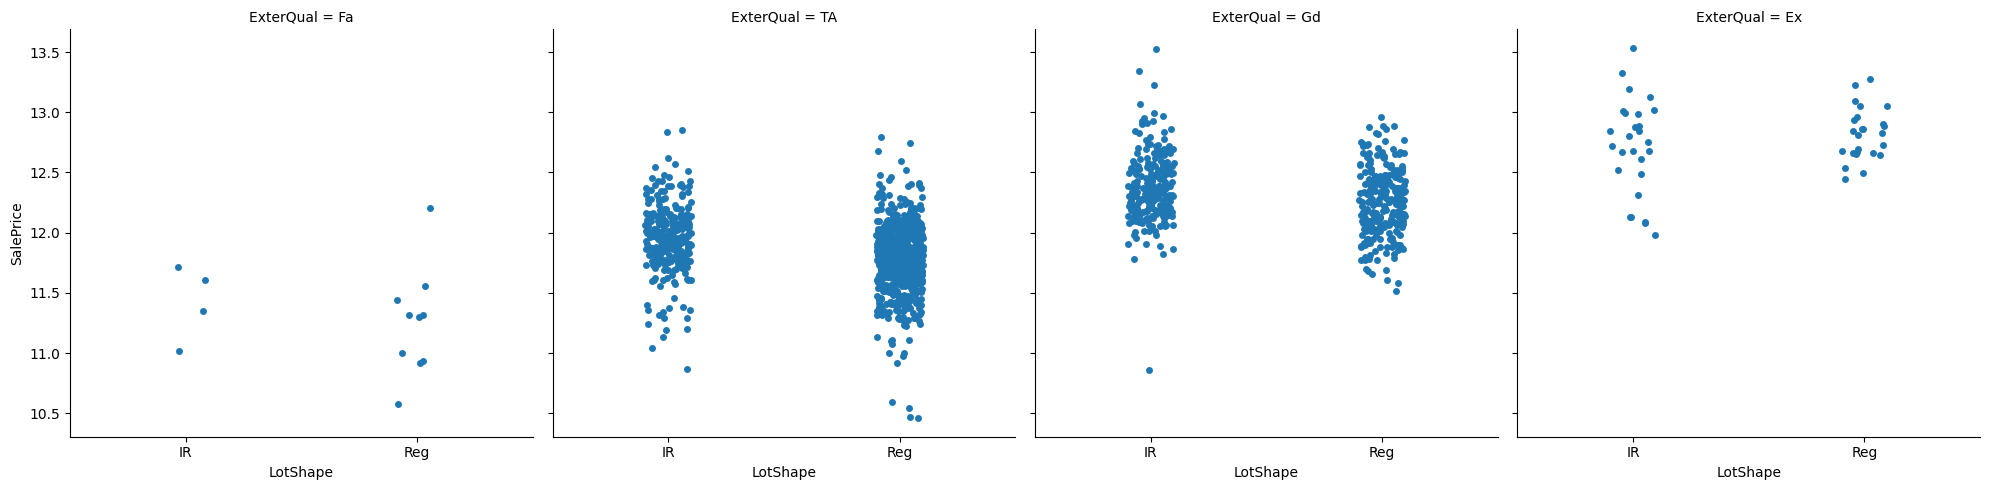

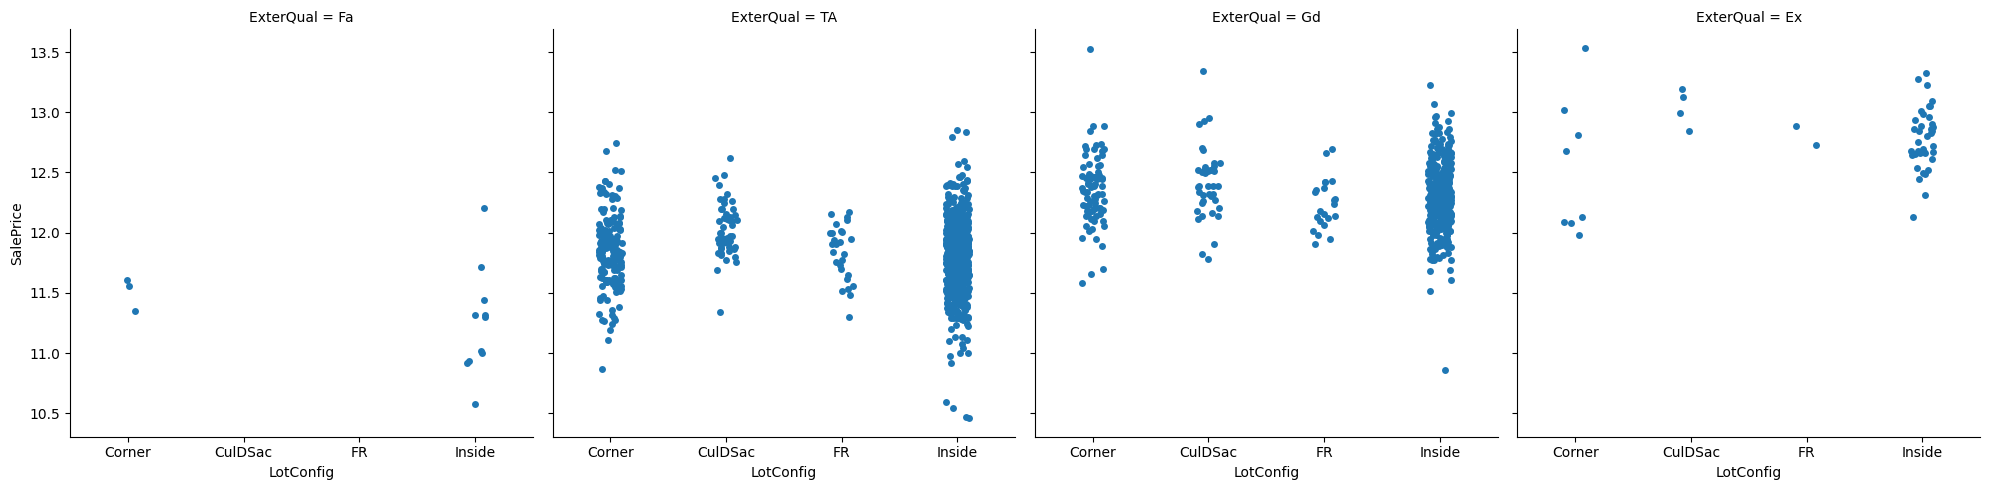

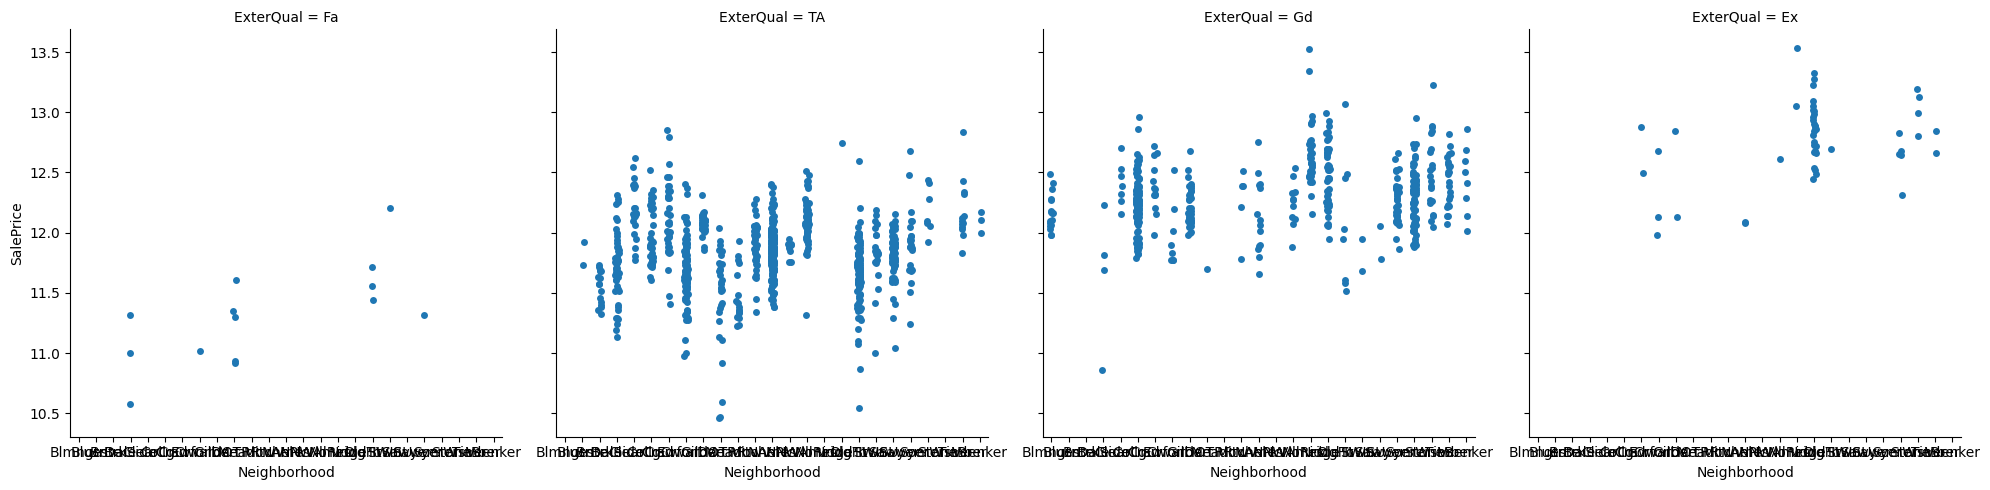

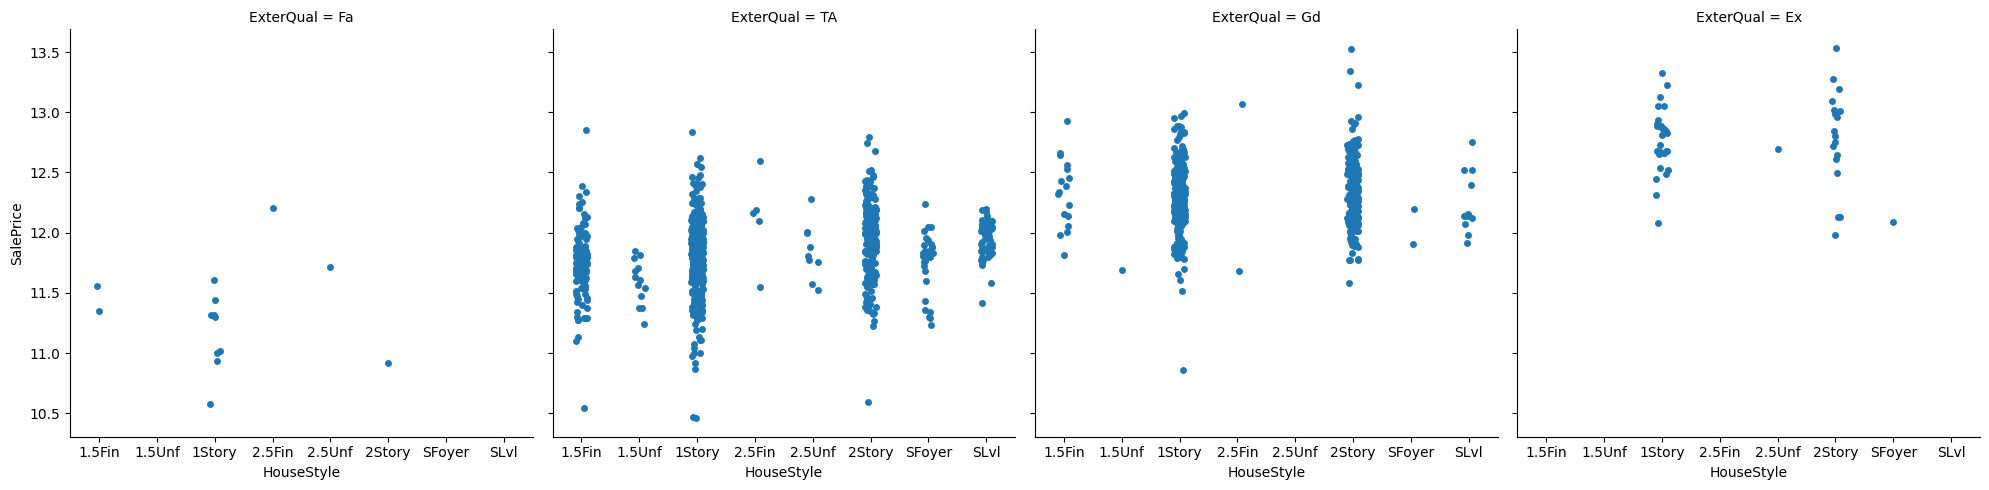

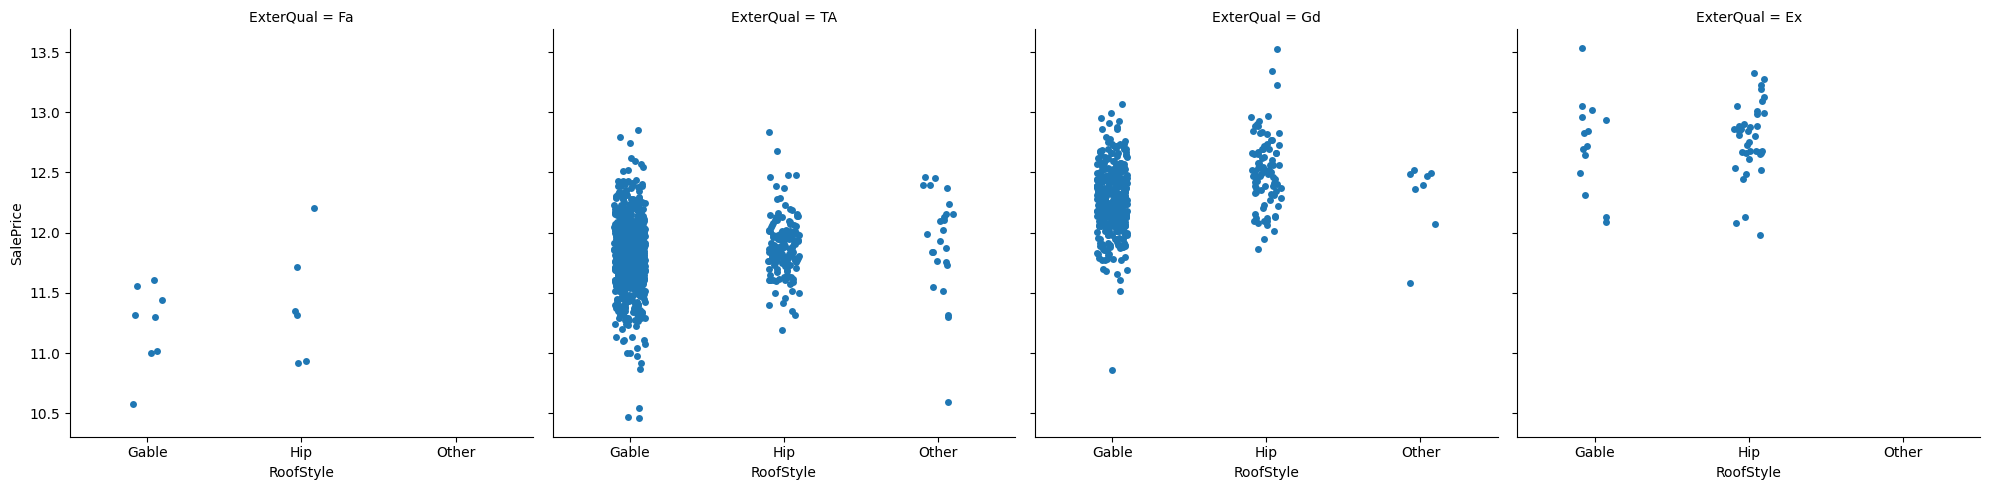

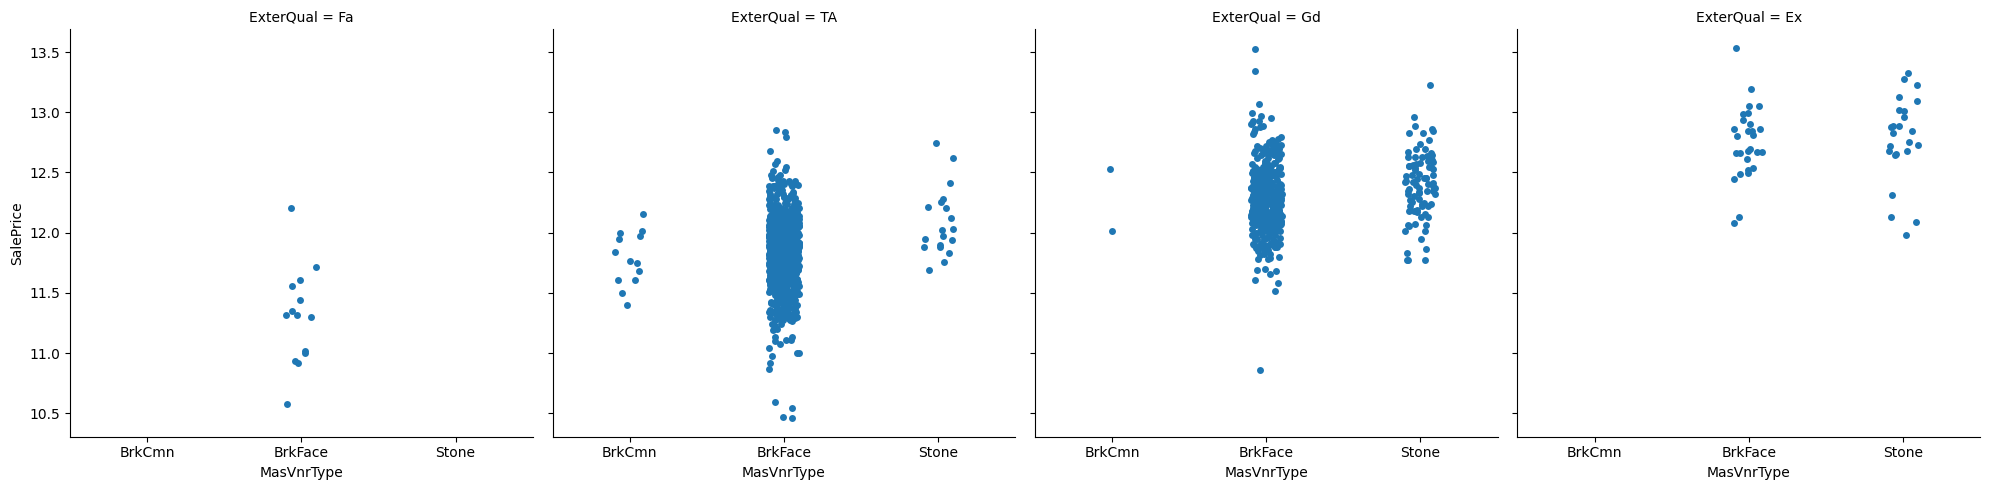

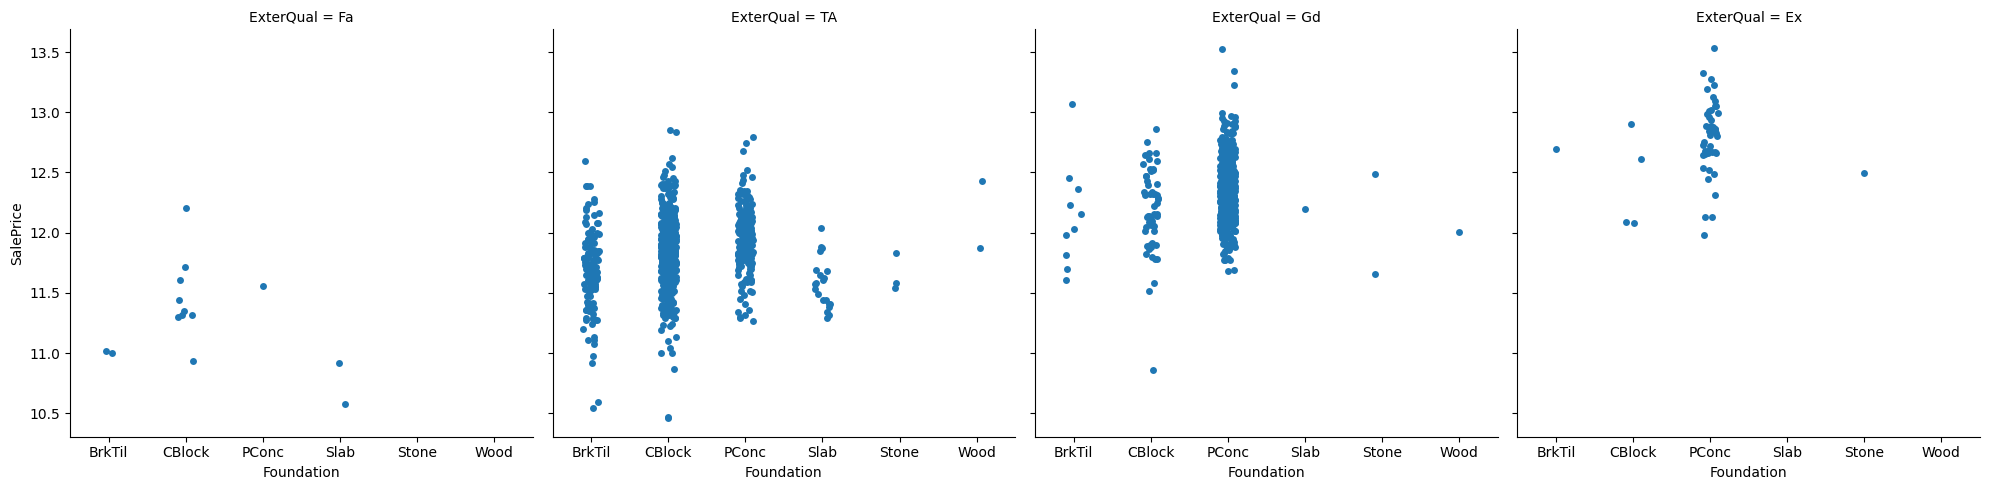

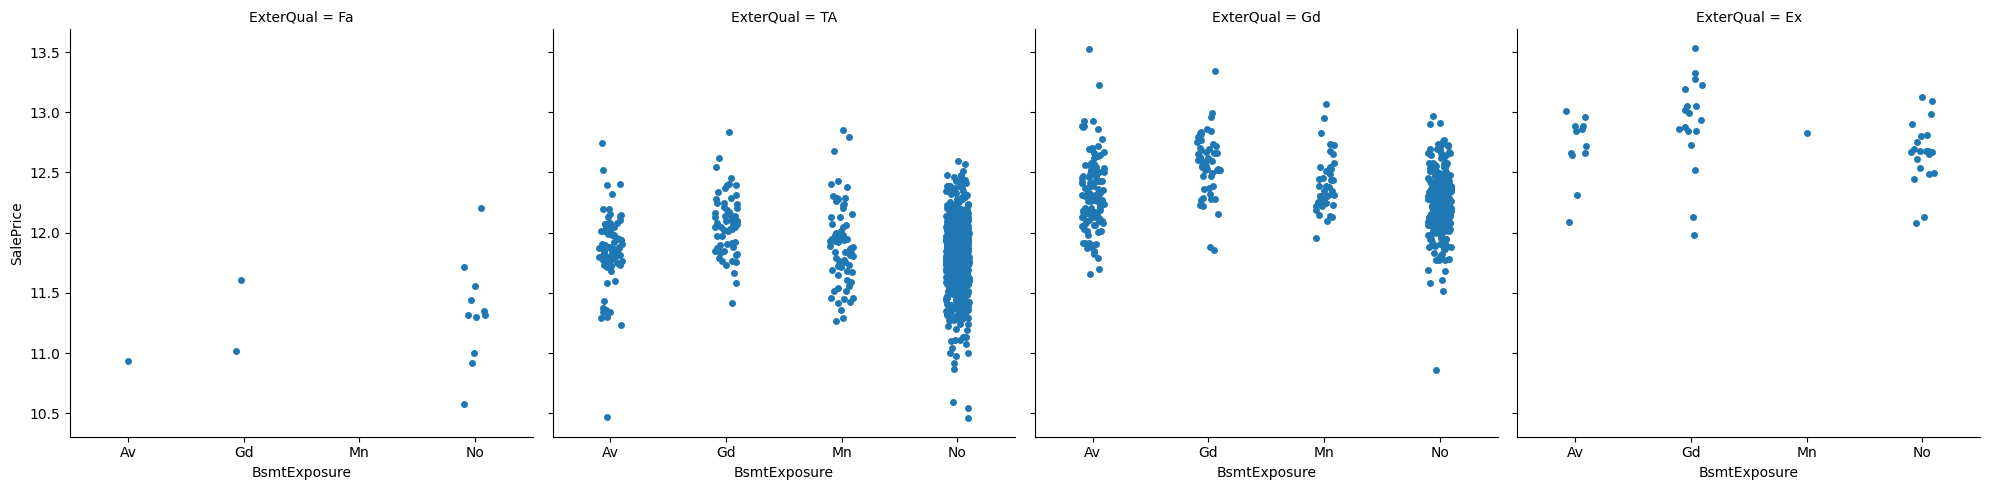

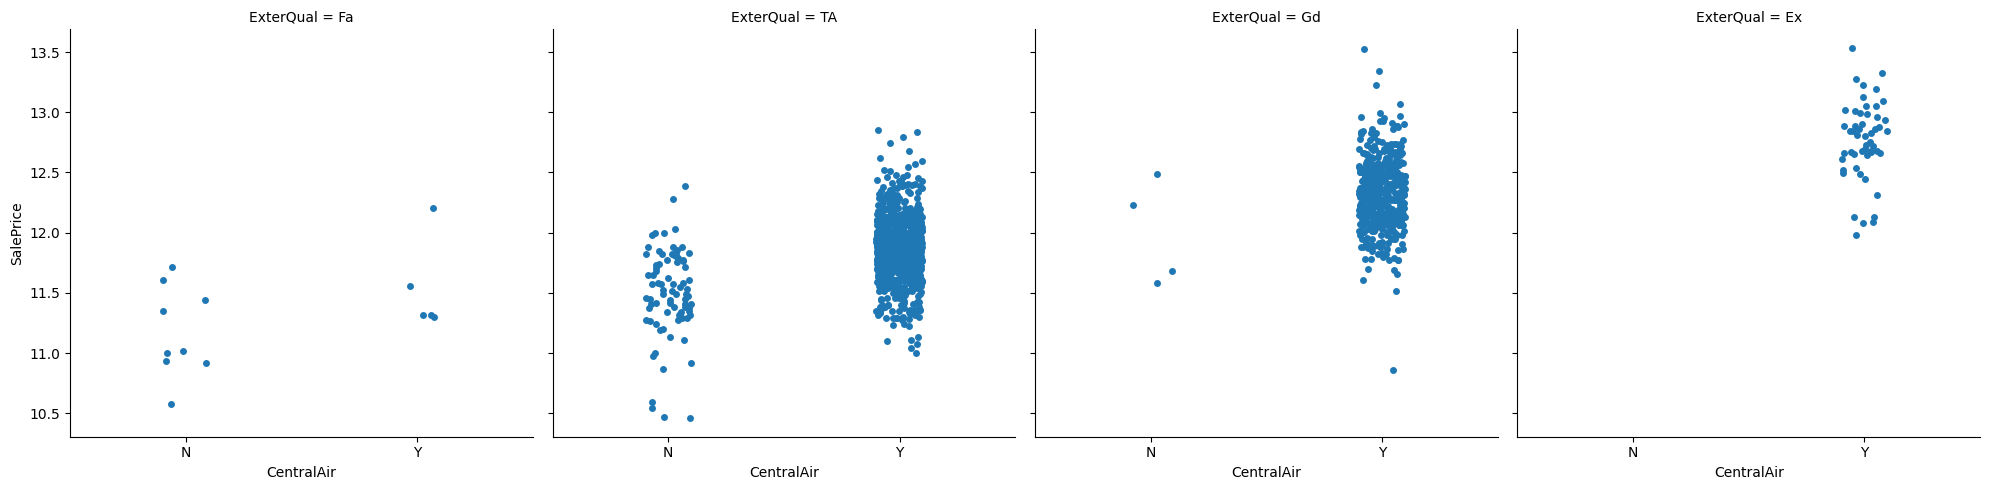

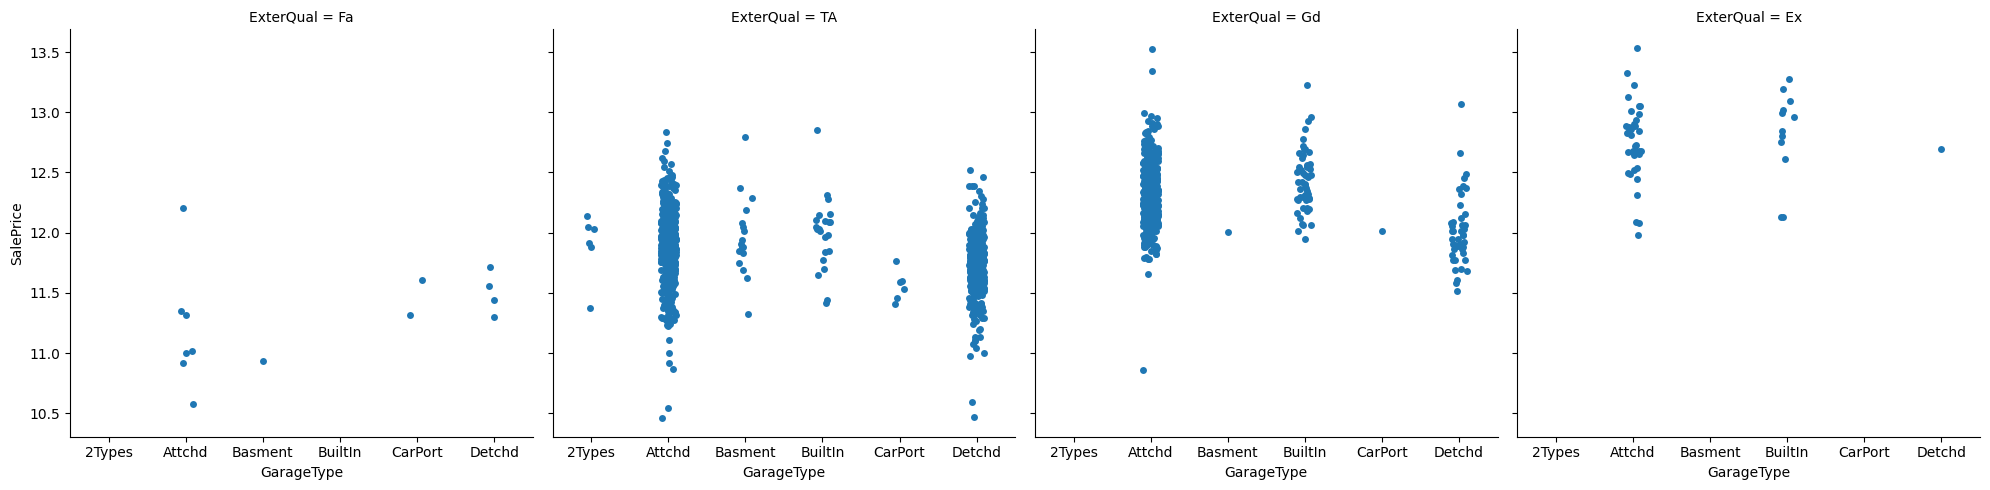

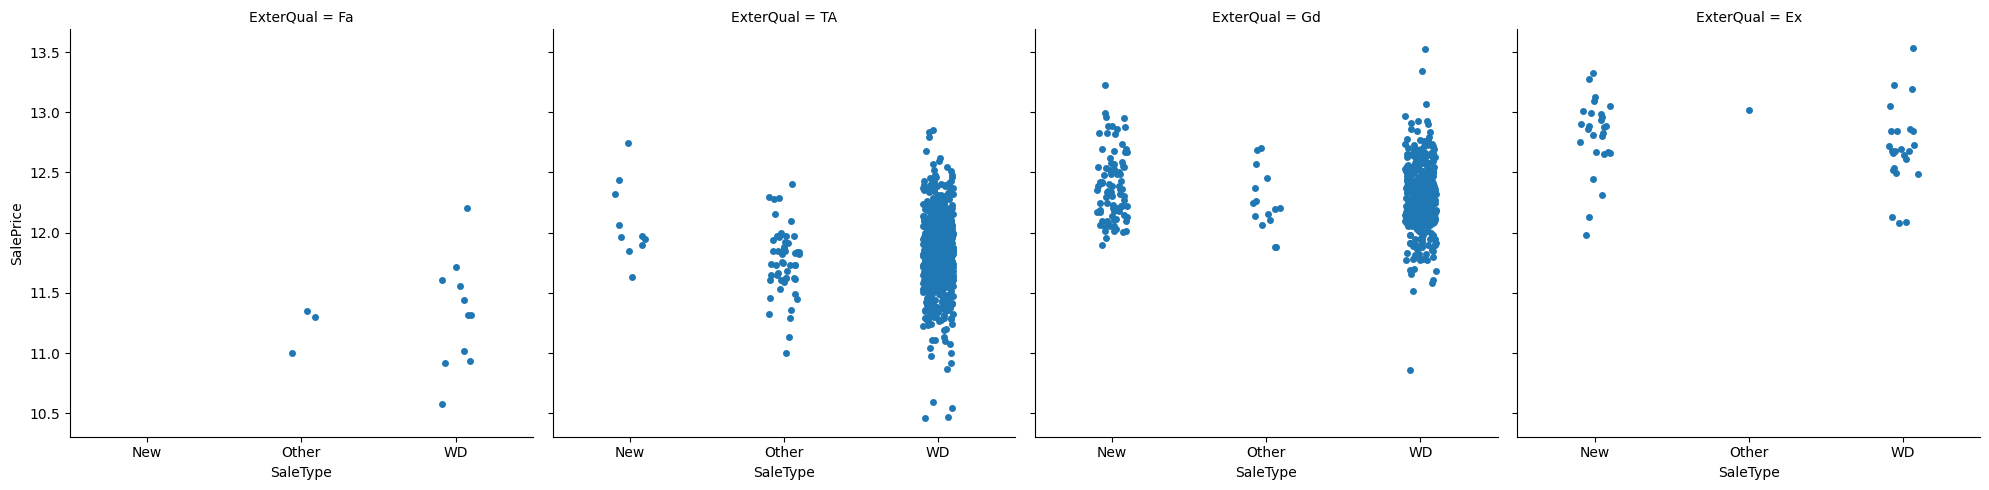

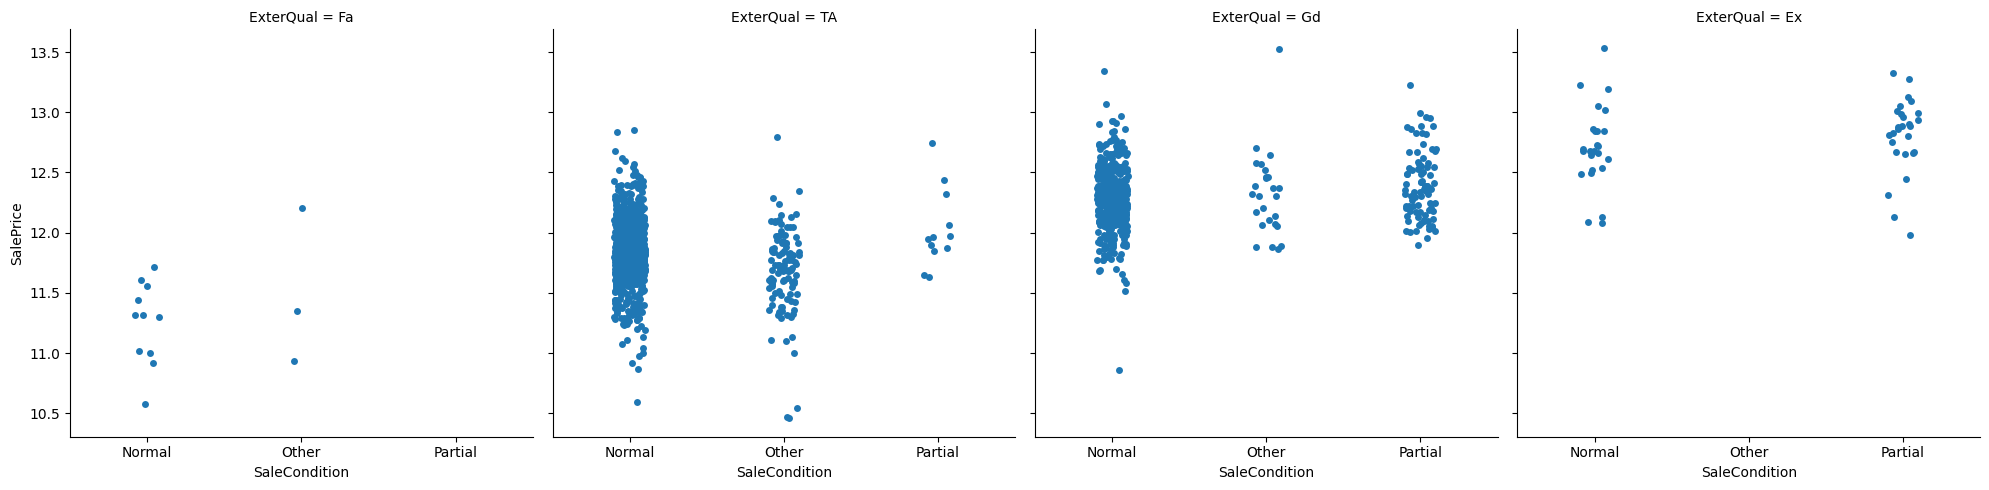

In [12]:
### Taking list of 'potential drivers' from univariate analysis, and faceting by ExterQual
for var in ['MSSubClass', 'LotShape', 'LotConfig', 'Neighborhood', 'HouseStyle', 'RoofStyle', 
'MasVnrType', 'Foundation', 'BsmtExposure', 'CentralAir', 'GarageType', 'SaleType', 'SaleCondition']:
    g = sns.catplot(data=train, x=var, y='SalePrice', col='ExterQual', kind='strip', col_order=['Fa','TA','Gd','Ex'])
    # plt.yscale('log')

### Numerical Variables

Ideas for analysis
* add some measure of correlation 

#### Correlation Matrix

Observations
* Strongest correlation with SalePrice: OverallQual and GrLivArea
* Strong correlation between:
    * Lot Frontage and Area - already saw this when filling in blanks
    * 1stFlr and TotalBsmt SF - makes sense
    * TotRmsAbvGrd and GrLivArea - more rooms = more area
    * GarageArea and GarageCars - prob can remove GarageCars since Garage Area is a stronger predictor
* Variables with a lot of weak and medium correlations with other variables
    * Quality - OverallQual
    * Area - TotalBmtSF & 1stFlrSF & GrLivArea
    * Rooms - FullBath & TotRmsAbvGr
    * Garagge- GarageCars & GarageArea
    * Age - age_sold,  age_remodel_sold, age_garage_sold

<Axes: >

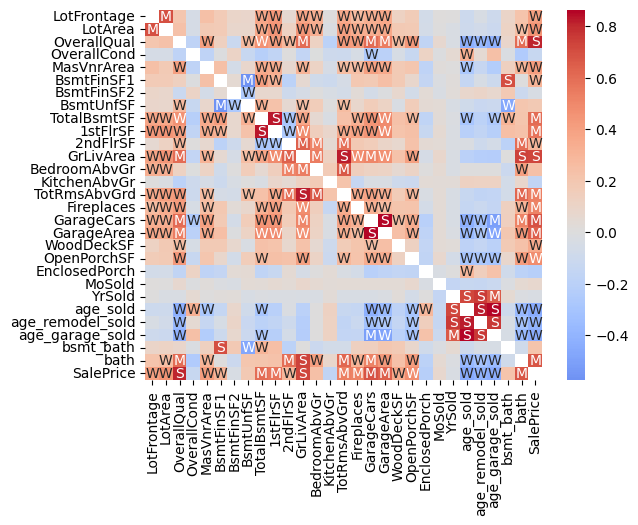

In [13]:
### create correlation matrix
cols_num.append('SalePrice')
corr_matrix = train[cols_num].corr(method='spearman')

# Create S/M/W annotations for correlation matrix
corr_annot = np.where(np.abs(corr_matrix)>0.70, "S", np.where(np.abs(corr_matrix)>0.5, "M", np.where(np.abs(corr_matrix)>0.25, "W", "")))

### create heatmap of correlations
sns.heatmap(data=corr_matrix, center=0, cmap='coolwarm', mask=np.eye(len(corr_matrix)), annot=corr_annot, fmt='', xticklabels=True, yticklabels=True)

#### Linear Regression plot

OverallQual - seems to be strong predictor based on univariate analysis

Observations
* Couldn't get the linear reg lines to vary by OverallQual - so can't really draw any conclusions here

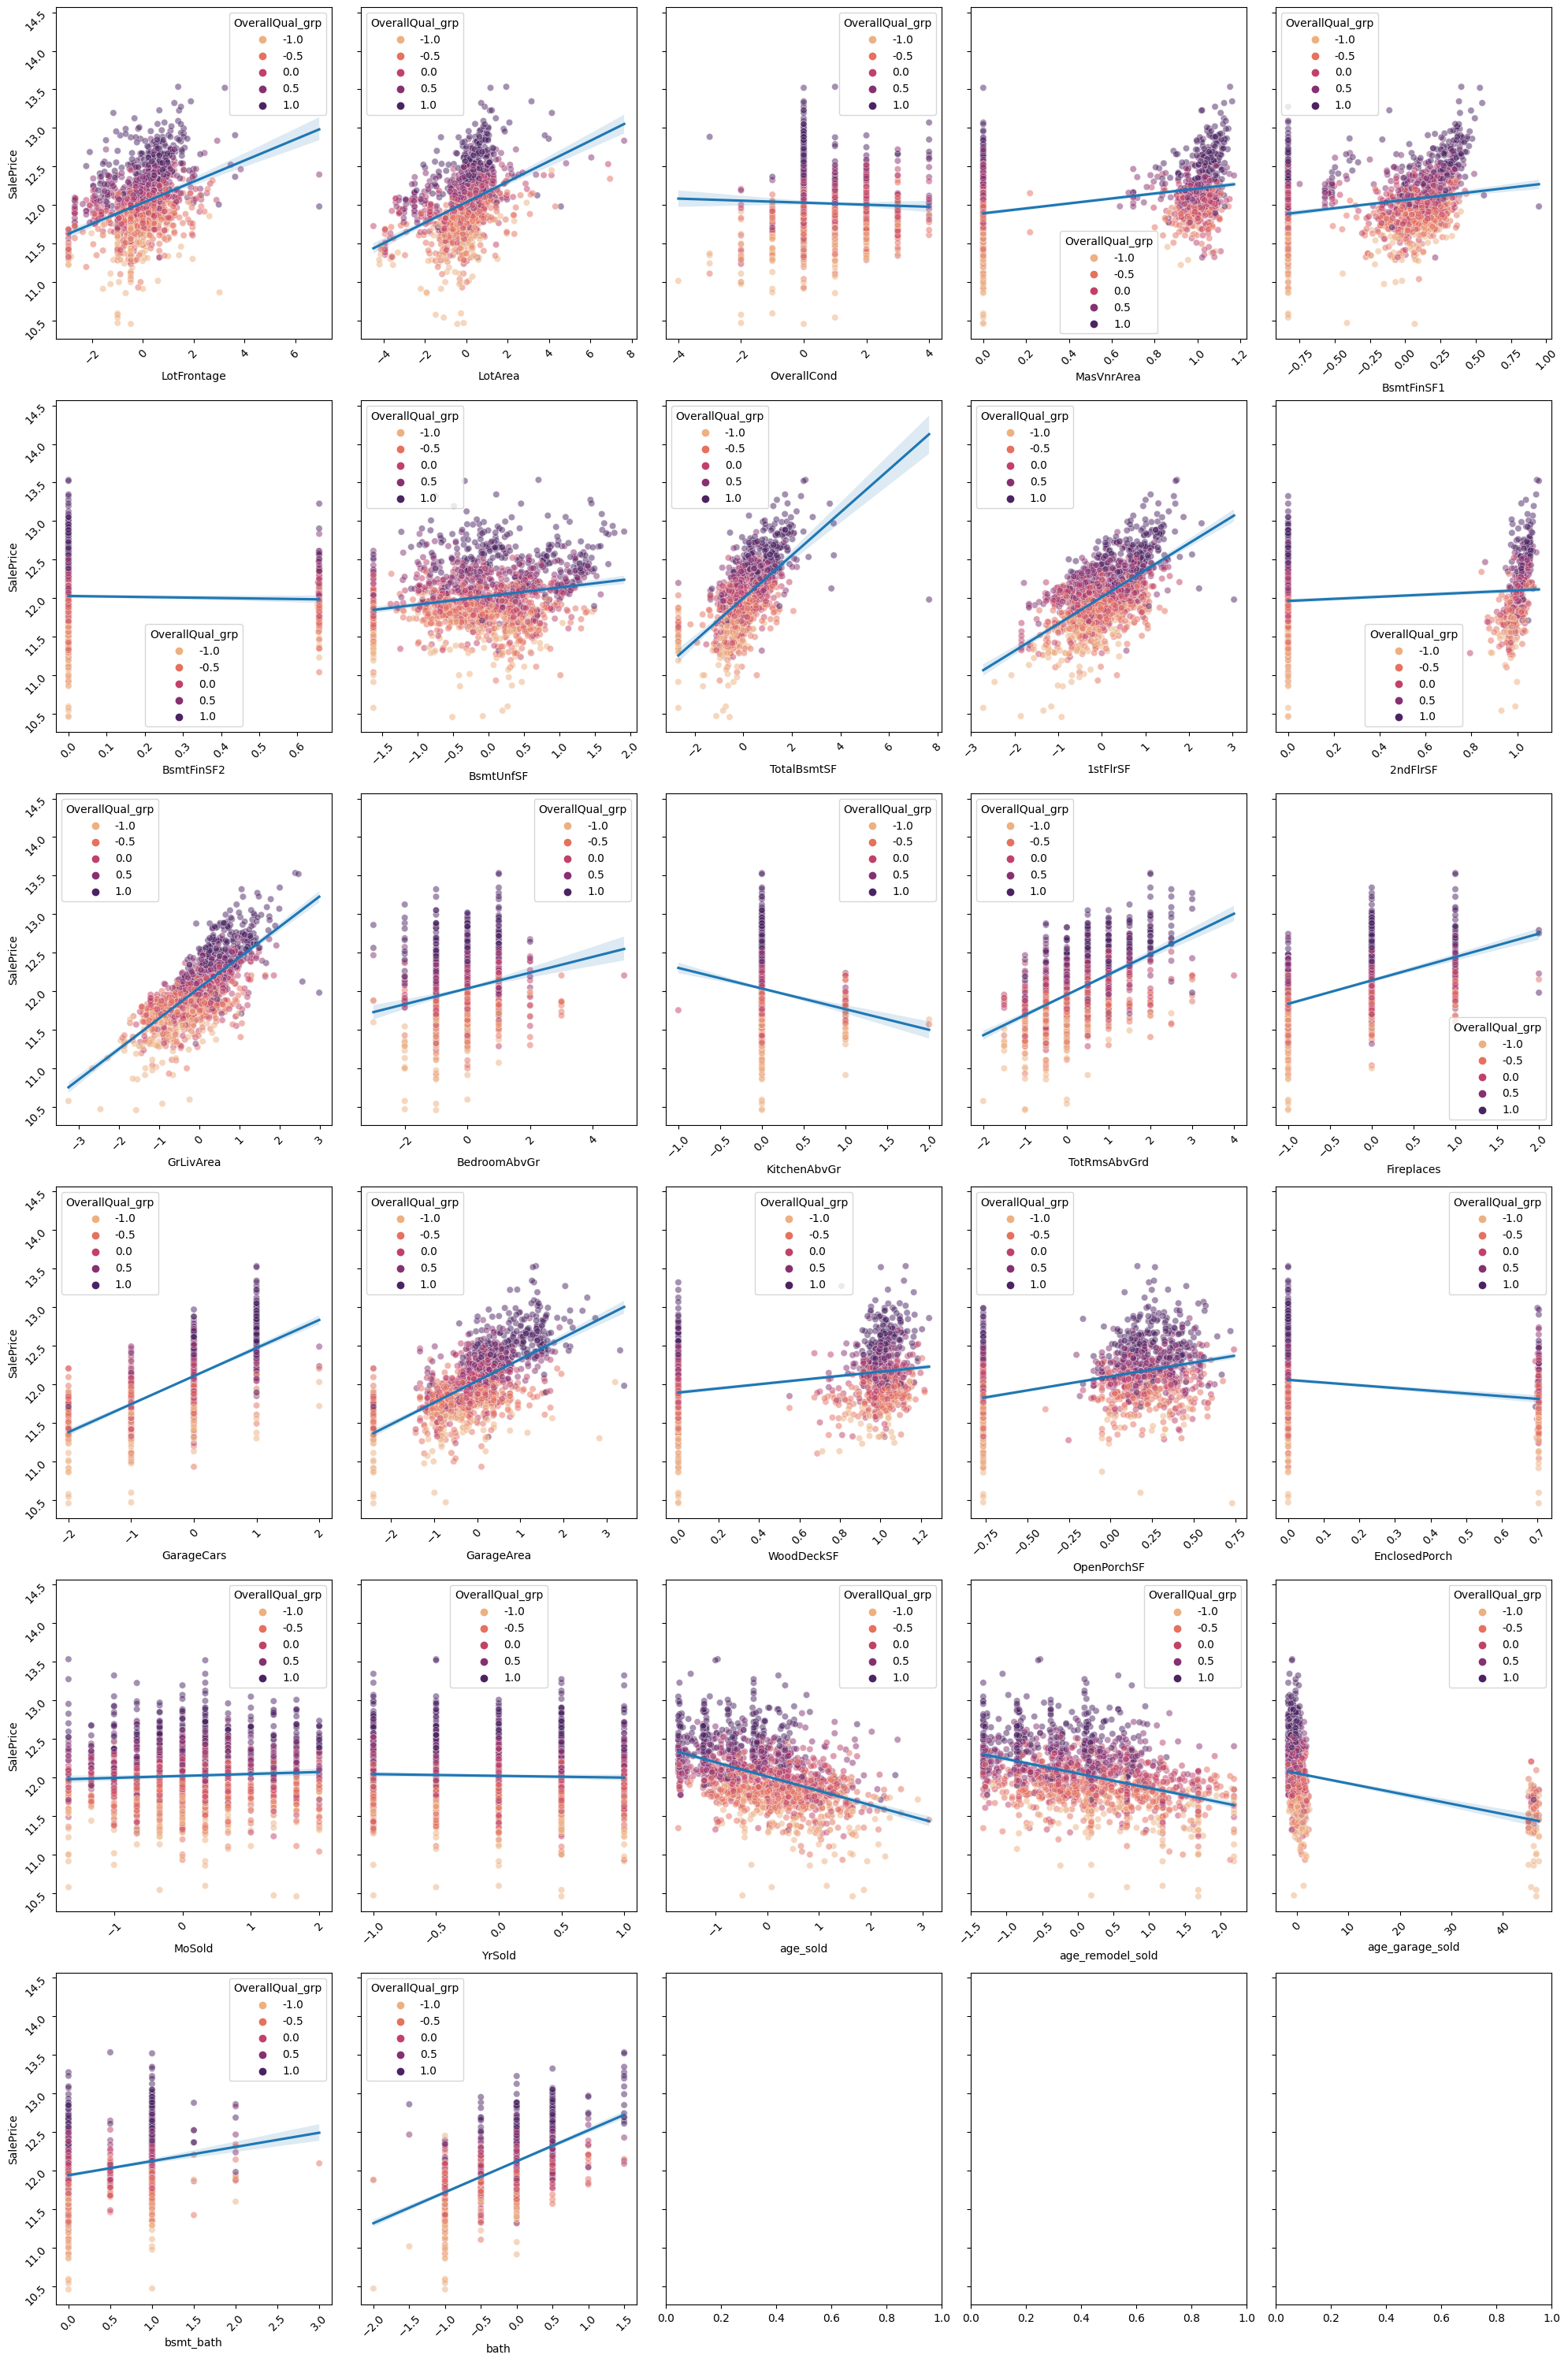

In [14]:
### create grouped OverallQual column
train['OverallQual_grp'] = np.where(train['OverallQual']>1, 1, train['OverallQual'])


### set up grid of subplots, then fill it with regression plot of each numerical variable vs SalePrice
cols_num.remove('SalePrice')

fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20,30), sharey=True)
for i, col in enumerate([c for c in cols_num if c!='OverallQual']):
    ax = axes.ravel()[i]
    sns.scatterplot(data=train, x=col, y='SalePrice', hue='OverallQual_grp', palette='flare', ax=ax, alpha=0.5)
    sns.regplot(data=train, x=col, y='SalePrice', ax=ax, scatter=False)
    # ax.set_yscale('log')
    ax.tick_params(labelrotation=45)
plt.tight_layout()

## Save Cleaned Data

In [15]:
## drop intermediary/analysis-only columns
train.drop(['DateSold', 'OverallQual_grp'], axis=1, inplace=True)

## save a csv
train.to_csv('train_clean_truncated.csv', index=False)

## Sandpit (i.e. rough drafts)


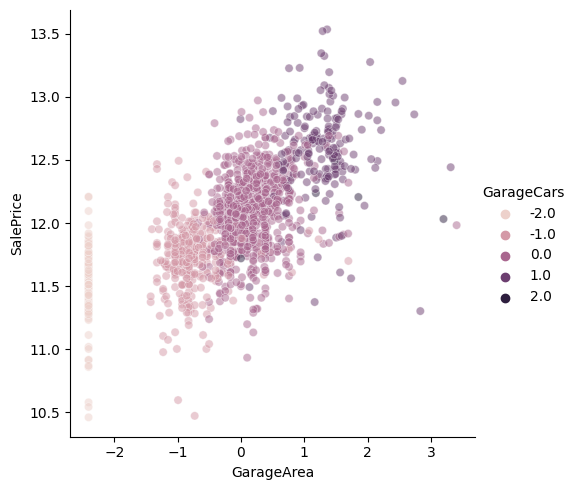

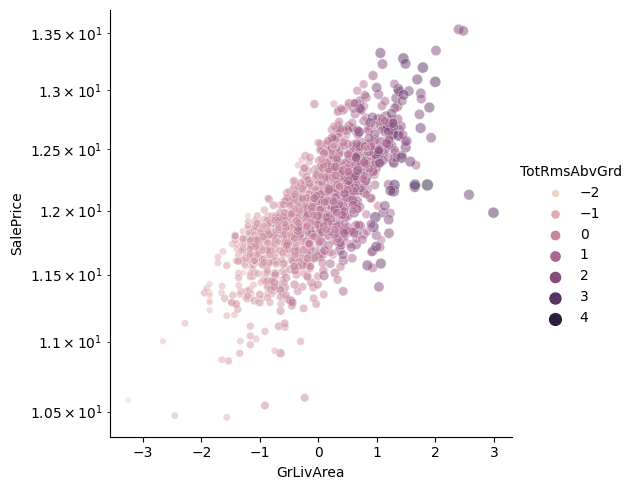

In [16]:
sns.relplot(data=train, x='GarageArea', y='SalePrice', hue='GarageCars', alpha=0.5)
sns.relplot(data=train, x='GrLivArea', y='SalePrice', hue='TotRmsAbvGrd', size='TotRmsAbvGrd', alpha=0.5)
plt.yscale('log')